In [1]:
from random import random,gauss, randint
import random
import string
import numpy as np
from faker import Faker
import pandas as pd
import datetime
import calendar

faker=Faker()

country_iso_codes=['IE', 'GB', 'ES', 'IT', 'PT', 'PL', 'FR', 'DE', 'NL', 'CZ', 'BE', 'AT', 'CH', 'SE', 'FI']

domestic_input_tax_codes = {
    'I1':(0.23, '23% Input VAT'),
    'I2':(0.15, '16% Input VAT'),
    'I3': (0.5, '5% Input VAT'),
    'I4': (0.0, '0% Input VAT')
}

domestic_output_tax_codes = {
    'O1': (.23, '23% Output VAT'),
    'O2': (.15, '15% Output VAT'),
    'O3': (.5, '5% Output VAT'),
    'O4': (0, '0% Output VAT')
}

ic_tax_codes = {
    'F1': (0, 'IC_Sale'),
    'F9': (0, 'IC_Purchase')
}

# generate a VAT ID in format IE12345678A
def generate_vat_id(country_iso):
    number=country_iso
    for i in range(8):
        number += str(randint(0,9))
    number += random.choice(string.ascii_letters).capitalize()
    return number

# Generate transaction (date in datetime object format)
def generate_transaction(trans_type,country_iso, trans_value_mean, trans_value_std, start, end):
    Trans_Date = faker.date_time_between(start_date=start, end_date=end)
    if trans_type == 'domestic_sale' or 'domestic_purchase':
        country_iso_vat = country_iso
    else:
        country_iso_codes.remove(country_iso)
        country_iso_vat = random.choices(country_iso_codes)[0]
    VAT_ID = generate_vat_id(country_iso_vat)
    Company = faker.company()
    Tax_Base_Amount= round(abs(gauss(trans_value_mean,trans_value_std)),2)
    
    
    if trans_type == 'domestic_sale':
        tax_codes = domestic_output_tax_codes
        Tax_Code = random.choices(list(tax_codes.keys()), weights=(60,20,10,10))[0]
    if trans_type == 'domestic_purchase':
        tax_codes = domestic_input_tax_codes
        Tax_Code = random.choices(list(tax_codes.keys()), weights=(60,20,10,10))[0]
    if trans_type == 'ic_sale':
        Tax_Code = 'F1'
    if trans_type == 'ic_purchase':
        Tax_Code = 'F9'
    if trans_type == 'domestic_sale' or trans_type == 'domestic_purchase':
        Tax_Rate = tax_codes[Tax_Code][0]
    else:
        Tax_Rate = 0.0
        
    Tax = Tax_Base_Amount * Tax_Rate
    return[Trans_Date,VAT_ID, Company, Tax_Base_Amount, Tax_Code, Tax_Rate, Tax]

# Generate monthy transactions
def generate_monthly_transactions(trans_type,country_iso,trans_value_mean, trans_value_std,monthly_vol_mean, monthly_vol_std,month,year):
    start = datetime.date(year,month,1)
    end = datetime.date(year, month, calendar.monthrange(year, month)[1])
    monthly_transactions_volume = int(abs(gauss(monthly_vol_mean,monthly_vol_std)))
    transactions_dict = {}
    
    for i in range(monthly_transactions_volume):
        transactions_dict[i] = generate_transaction(trans_type,country_iso,trans_value_mean, trans_value_std,start, end)
        
    transactions_df = pd.DataFrame.from_dict(transactions_dict, orient='index')
    pd.options.display.float_format = '€{:,.2f}'.format

    transactions_df.columns = ['trans_date', 'vat_id', 'company', 'tax_base', 'tax_code', 'tax_rate', 'tax']
    
    return transactions_df

        
# Generate annual domestic transactions (done by month so there's more variance each month)
def generate_annual_transactions(trans_type,country_iso,trans_value_mean, trans_value_std,monthly_vol_mean, monthly_vol_std,year):
    df = generate_monthly_transactions(trans_type,country_iso,trans_value_mean, trans_value_std ,monthly_vol_mean, monthly_vol_std,1,year)
    for i in range(2,13):
        new_month = generate_monthly_transactions(trans_type,country_iso,trans_value_mean, trans_value_std,monthly_vol_mean, monthly_vol_std,i,year)
        df = pd.concat([df,new_month])
        df = df.sort_values(by='trans_date')
        print(f"Month {i} completed")
    print(f"{trans_type} completed")
    return df

domestic_sales = generate_annual_transactions('domestic_sale',"GB",1000,200,5000,300,2019)
domestic_purchases = generate_annual_transactions('domestic_purchase',"GB",300,100,3000,300,2019)
ic_sales = generate_annual_transactions('ic_sale',"GB",300,100,3000,300,2019)
ic_purchases = generate_annual_transactions('ic_purchase',"GB",300,100,3000,300,2019)



Month 2 completed
Month 3 completed
Month 4 completed
Month 5 completed
Month 6 completed
Month 7 completed
Month 8 completed
Month 9 completed
Month 10 completed
Month 11 completed
Month 12 completed
domestic_sale completed
Month 2 completed
Month 3 completed
Month 4 completed
Month 5 completed
Month 6 completed
Month 7 completed
Month 8 completed
Month 9 completed
Month 10 completed
Month 11 completed
Month 12 completed
domestic_purchase completed
Month 2 completed
Month 3 completed
Month 4 completed
Month 5 completed
Month 6 completed
Month 7 completed
Month 8 completed
Month 9 completed
Month 10 completed
Month 11 completed
Month 12 completed
ic_sale completed
Month 2 completed
Month 3 completed
Month 4 completed
Month 5 completed
Month 6 completed
Month 7 completed
Month 8 completed
Month 9 completed
Month 10 completed
Month 11 completed
Month 12 completed
ic_purchase completed


In [14]:
df = pd.concat([domestic_sales,domestic_purchases,ic_sales,ic_purchases])
df = df.drop(['tax_rate'], axis=1)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df['Month']  = df.trans_date.dt.month
df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])
df['Month'] = pd.Categorical(df['Month'], categories=months, ordered=True)


df['Year'] = df.trans_date.dt.year
df['Year'] = df.Year.astype(str)
df

,trans_date,vat_id,company,tax_base,tax_code,tax,Month,Year
889,2019-01-01 00:06:16,GB68778499T,"Tucker, Taylor and Mitchell",€870.86,O4,€0.00,Jan,2019
95,2019-01-01 00:10:00,GB04132985N,"Peterson, Burton and Holmes",€803.52,O4,€0.00,Jan,2019
3086,2019-01-01 00:12:33,GB57545621R,"Thomas, Norton and Charles","€1,088.51",O1,€250.36,Jan,2019
1722,2019-01-01 00:19:00,GB87869421Q,"Ramirez, Munoz and Gonzalez","€1,172.53",O1,€269.68,Jan,2019
3674,2019-01-01 00:48:02,GB69538646G,Carter-Hanson,€892.66,O1,€205.31,Jan,2019
...,...,...,...,...,...,...,...,...
1242,2019-12-30 23:01:47,GB90853436I,Solis-Haynes,€286.87,F9,€0.00,Dec,2019
66,2019-12-30 23:17:53,GB75992749O,"Dean, Rivera and Arellano",€235.26,F9,€0.00,Dec,2019
1520,2019-12-30 23:47:53,GB70322901X,Hansen and Sons,€331.25,F9,€0.00,Dec,2019
9,2019-12-30 23:51:05,GB95610399A,Sims-Roberts,€283.20,F9,€0.00,Dec,2019


In [15]:
by_month = df.groupby(['Month']).sum()

In [16]:
by_month.sort_values(by='Month')

,tax_base,tax
Month,,
Jan,"€7,928,693.01","€1,364,960.58"
Feb,"€7,373,908.41","€1,221,200.46"
Mar,"€7,989,863.87","€1,328,006.83"
Apr,"€7,264,683.15","€1,147,335.95"
May,"€7,716,615.69","€1,259,267.20"
Jun,"€7,786,068.33","€1,260,458.88"
Jul,"€7,522,051.45","€1,293,301.82"
Aug,"€8,097,636.45","€1,380,495.71"
Sep,"€7,780,198.79","€1,335,672.26"


Month
Jan   €7,928,693.01
Feb   €7,373,908.41
Mar   €7,989,863.87
Apr   €7,264,683.15
May   €7,716,615.69
Jun   €7,786,068.33
Jul   €7,522,051.45
Aug   €8,097,636.45
Sep   €7,780,198.79
Oct   €7,749,191.02
Nov   €8,078,927.71
Dec   €6,600,295.26
Name: tax_base, dtype: float64


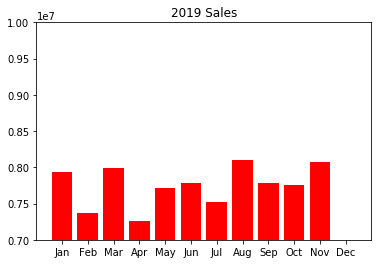

In [19]:
import matplotlib.pyplot as plt

base = by_month.tax_base

print(base)

plt.bar(base.index,base, color='red')
plt.title('2019 Sales')
plt.ylim(7000000, 10000000)

plt.show()

In [25]:
pd.options.display.max_rows = 100
pd.pivot_table(df, index=['Month', 'tax_code'], values='tax_base', aggfunc=np.sum)


tax_base
Month tax_code              
Jan   F1         €785,383.67
      F9         €860,241.31
      I1         €634,294.06
      I2         €204,304.68
      I3          €94,903.51
...                      ...
Dec   I4          €83,443.74
      O1       €2,491,630.86
      O2         €798,498.51
      O3         €393,142.52
      O4         €390,118.83

[120 rows x 1 columns]